<a href="https://colab.research.google.com/github/casualcomputer/statistics_applications/blob/main/policy_effect_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Difference-in-Difference estimation

Basic equation:

-  $Sales_{i}$ = $\beta_0$+ $\beta_1$* Indicator(is quebec)+ $\beta_2$* Indicator(after policy in effect)+ $\beta_3$* Indicator(is quebec)* Indicator(after policy in effect)$

Before policy in effect:
* quebec: $\beta_0$ + $\beta_1$
* non-quebec provinces: $\beta_0$
* **provincial_delta_pre_policy(quebec, non-quebec)** = $\beta_1$

After policy in effect:
* quebec: $\beta_0$ + $\beta_1$ +$\beta_2$ +$\beta_3$
* non-quebec provinces: $\beta_0$ +$\beta_2$
* **provincial_delta_post_policy(quebec, non-quebec)** = $\beta_1$ + $\beta_3$

Note: $\beta_3$ is the diffences between quebec and non-quebec provinces, as a result of the policy implementation.

Important things to consider:

1. policy may apply to different products (e.g. vehicles with different watts ratings) at different rebate levels

2. we are making the following statistical assumptions:

*   **consistency:** non-quebec group never received the policy rebates, quebec only received the rebate after the policy was put in effect.
*   **arrow-of-time:** future policy doesn't affect past outcomes, i.e., the cause (policy implementation) occurs before its effects (changes in sales).
*   **parallel trends:** in the absence of the rebate policy, Quebec and non-Quebec provinces would have experienced similar trends in sales over time



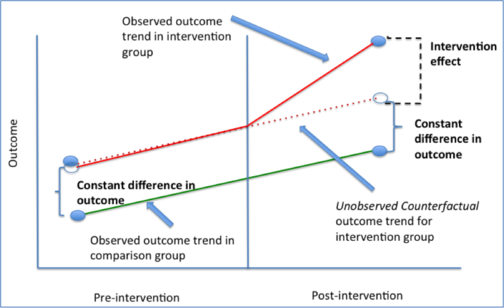

More literature: https://diff.healthpolicydatascience.org/

Picture: https://learncuriously.wordpress.com/2021/06/18/pre-post-analysis/

# Basic DID model

In [296]:
install.packages("lubridate")
#install.packages("reactable")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [297]:

# Load the readr library
library(readr)

# Load the CSV data directly from the URL using read_csv
data <- read_csv("https://raw.githubusercontent.com/casualcomputer/statistics_applications/main/2010002401_databaseLoadingData.csv")

# View the first few rows of the dataframe to check the data
head(data)


Rows: 1450 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): REF_DATE, GEO, DGUID, Fuel type, Vehicle type, Statistics, UOM, SC...
dbl  (4): UOM_ID, SCALAR_ID, VALUE, DECIMALS
lgl  (2): SYMBOL, TERMINATED

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


REF_DATE,GEO,DGUID,Fuel type,Vehicle type,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>
2017-01,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2017-04,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2017-07,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2017-10,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2018-01,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0
2018-04,Newfoundland and Labrador,2016A000210,Battery electric,"Total, vehicle type",Number of vehicles,Units,300,units,0,v1271719105,2.4.1.1,NA,..,NA,NA,0


In [298]:
# Selecting columns by their indices
selected_data <- data[, c(1, 2, 4, 5,13)]

# View the first few rows of the selected columns to verify
library(lubridate)
selected_data$REF_DATE <- lubridate::as_date(ym(selected_data$REF_DATE))

# View the first few rows to confirm the change
head(selected_data)

# show unique values
unique(selected_data$GEO) #'Battery electric'
unique(selected_data$`Fuel type`) #'Battery electric'
unique(selected_data$`Vehicle type`) #'Total, vehicle type''Passenger cars''Pickup trucks''Multi-purpose vehicles''Vans'


REF_DATE,GEO,Fuel type,Vehicle type,VALUE
<date>,<chr>,<chr>,<chr>,<dbl>
2017-01-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2017-04-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2017-07-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2017-10-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2018-01-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA
2018-04-01,Newfoundland and Labrador,Battery electric,"Total, vehicle type",NA


[1] "Newfoundland and Labrador"           
 [2] "Prince Edward Island"                
 [3] "Nova Scotia"                         
 [4] "New Brunswick"                       
 [5] "Quebec"                              
 [6] "Ontario"                             
 [7] "Manitoba"                            
 [8] "Saskatchewan"                        
 [9] "Alberta"                             
[10] "British Columbia and the Territories"

[1] "Battery electric"

[1] "Total, vehicle type"    "Passenger cars"         "Pickup trucks"         
[4] "Multi-purpose vehicles" "Vans"

In [299]:
# create indicators
library(dplyr)
df <- selected_data %>%
  mutate(is_quebec = case_when(
    str_detect(GEO, "Quebec") ~ 1,  # Detects 'Quebec' in the 'region' column
    TRUE ~ 0  # Default case, assigns 0 if not 'Quebec'
  ),
  after_policy = case_when(
    REF_DATE>=as.Date("2023-04-18") ~ 1,
    TRUE ~ 0
  ),
  ref_year = year(REF_DATE)
) %>%
  filter(VALUE!="NA")
names(df) = c("ref_date","province","fuel_type","vehicle_type","registrations","is_quebec","after_policy","ref_year")
head(df)

ref_date,province,fuel_type,vehicle_type,registrations,is_quebec,after_policy,ref_year
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2017-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-07-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-10-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2018-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",2,0,0,2018
2018-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",3,0,0,2018


In [300]:
library(dplyr)
library(stringr)

# Assuming df is your dataframe and it includes 'province', 'vehicle_type', and 'ref_year' columns
aggregated_df = df %>%
   filter(vehicle_type=="Total, vehicle type")
head(aggregated_df)

ref_date,province,fuel_type,vehicle_type,registrations,is_quebec,after_policy,ref_year
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2017-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-07-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2017-10-01,Prince Edward Island,Battery electric,"Total, vehicle type",0,0,0,2017
2018-01-01,Prince Edward Island,Battery electric,"Total, vehicle type",2,0,0,2018
2018-04-01,Prince Edward Island,Battery electric,"Total, vehicle type",3,0,0,2018


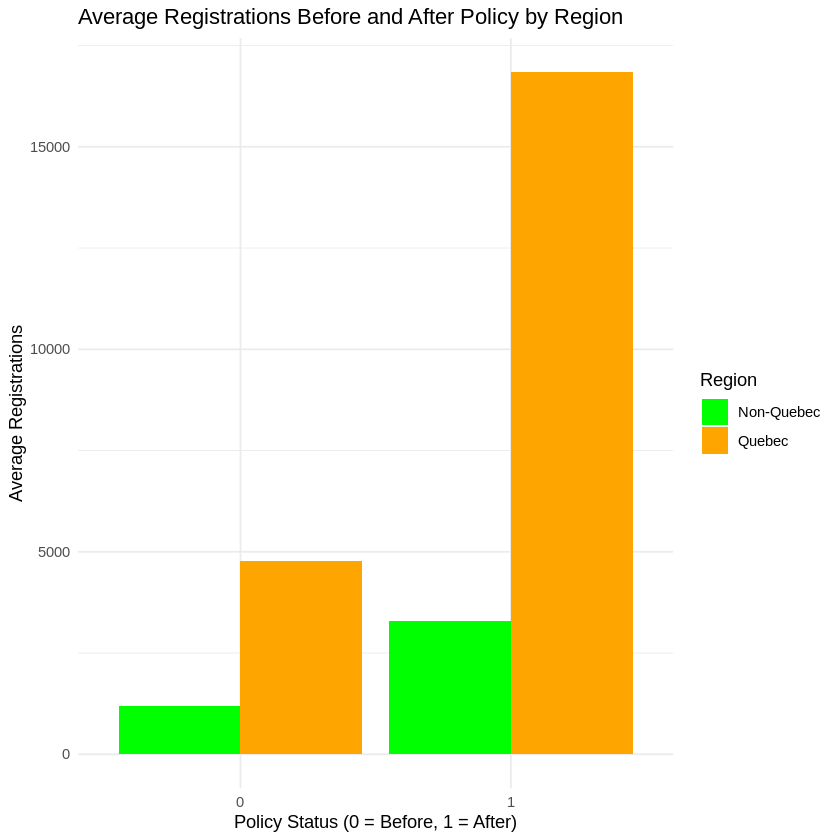

In [301]:
# Create a grouped bar chart to compare sales before and after policy by region
ggplot(aggregated_df, aes(x = as.factor(after_policy), y = registrations, fill = as.factor(is_quebec))) +
  geom_bar(stat = "summary", fun = "mean", position = position_dodge()) +
  labs(title = "Average Registrations Before and After Policy by Region",
       x = "Policy Status (0 = Before, 1 = After)",
       y = "Average Registrations",
       fill = "Region") +
  scale_fill_manual(values = c("green", "orange"),
                    labels = c("Non-Quebec", "Quebec")) +
  theme_minimal()


In [302]:
# Assuming `df` is your DataFrame with `sales` as the outcome, `year` for time, `is_quebec` as a group indicator, and `after_policy` as the post-policy period indicator

# Basic DiD model
basic_did <- lm(registrations ~ is_quebec * after_policy, data = aggregated_df) #beta3: 3982.86
summary(basic_did)



Call:
lm(formula = registrations ~ is_quebec * after_policy, data = aggregated_df)

Residuals:
   Min     1Q Median     3Q    Max 
 -4160  -1180  -1113    424   9401 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)              1185.3      212.6   5.575 8.00e-08 ***
is_quebec                3576.2      562.5   6.357 1.38e-09 ***
after_policy             2118.0      661.1   3.204  0.00158 ** 
is_quebec:after_policy   9957.1     1749.0   5.693 4.43e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2656 on 199 degrees of freedom
Multiple R-squared:  0.4141,	Adjusted R-squared:  0.4053 
F-statistic: 46.89 on 3 and 199 DF,  p-value: < 2.2e-16


## Checking parallel trend assumptions (of basic model)

In [304]:
# Augmented DiD model to check for parallel trends
aggregated_df$year_factor <- as.factor(year(aggregated_df$ref_date)) # Convert year to a factor if it isn't already
augmented_did <- lm(registrations ~ is_quebec * after_policy + is_quebec * year_factor, data = aggregated_df)
summary(augmented_did)


Call:
lm(formula = registrations ~ is_quebec * after_policy + is_quebec * 
    year_factor, data = aggregated_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3523.7 -1333.9  -555.0   794.6  7756.3 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  229.8      485.8   0.473 0.636713    
is_quebec                    606.9     1285.4   0.472 0.637359    
after_policy                 900.4      971.6   0.927 0.355294    
year_factor2018              331.1      687.1   0.482 0.630413    
year_factor2019              570.6      687.1   0.830 0.407341    
year_factor2020              633.3      687.1   0.922 0.357862    
year_factor2021             1181.0      687.1   1.719 0.087290 .  
year_factor2022             2252.0      687.1   3.278 0.001250 ** 
year_factor2023             2485.4      841.5   2.954 0.003548 ** 
year_factor2024             1548.3     1457.5   1.062 0.289490    
is_quebec:after_policy      4523.1     

In [306]:
# Event Study Approach
# Assuming `year_relative` is a factor variable for years relative to the treatment year (e.g., -2, -1, 0, 1, ...)
policy_year = 2023
aggregated_df$year_relative = as.factor(year(aggregated_df$ref_date) - policy_year)
str(aggregated_df)

event_study <- lm(registrations ~ after_policy * year_relative, data = aggregated_df)
summary(event_study)

tibble [203 × 10] (S3: tbl_df/tbl/data.frame)
 $ ref_date     : Date[1:203], format: "2017-01-01" "2017-04-01" ...
 $ province     : chr [1:203] "Prince Edward Island" "Prince Edward Island" "Prince Edward Island" "Prince Edward Island" ...
 $ fuel_type    : chr [1:203] "Battery electric" "Battery electric" "Battery electric" "Battery electric" ...
 $ vehicle_type : chr [1:203] "Total, vehicle type" "Total, vehicle type" "Total, vehicle type" "Total, vehicle type" ...
 $ registrations: num [1:203] 0 0 0 0 2 3 4 1 4 6 ...
 $ is_quebec    : num [1:203] 0 0 0 0 0 0 0 0 0 0 ...
 $ after_policy : num [1:203] 0 0 0 0 0 0 0 0 0 0 ...
 $ ref_year     : num [1:203] 2017 2017 2017 2017 2018 ...
 $ year_factor  : Factor w/ 8 levels "2017","2018",..: 1 1 1 1 2 2 2 2 3 3 ...
 $ year_relative: Factor w/ 8 levels "-6","-5","-4",..: 1 1 1 1 2 2 2 2 3 3 ...



Call:
lm(formula = registrations ~ after_policy * year_relative, data = aggregated_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5430.0 -1887.2  -316.5  1603.4 11924.1 

Coefficients: (7 not defined because of singularities)
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     316.5      594.3   0.533 0.594904    
after_policy                   1546.6     1188.6   1.301 0.194740    
year_relative-5                 469.1      840.5   0.558 0.577354    
year_relative-4                 915.4      840.5   1.089 0.277437    
year_relative-3                1032.8      840.5   1.229 0.220608    
year_relative-2                1693.2      840.5   2.015 0.045325 *  
year_relative-1                3027.9      840.5   3.603 0.000400 ***
year_relative0                 3658.9     1029.4   3.555 0.000476 ***
year_relative1                 2802.8     1782.9   1.572 0.117574    
after_policy:year_relative-5       NA         NA      NA      

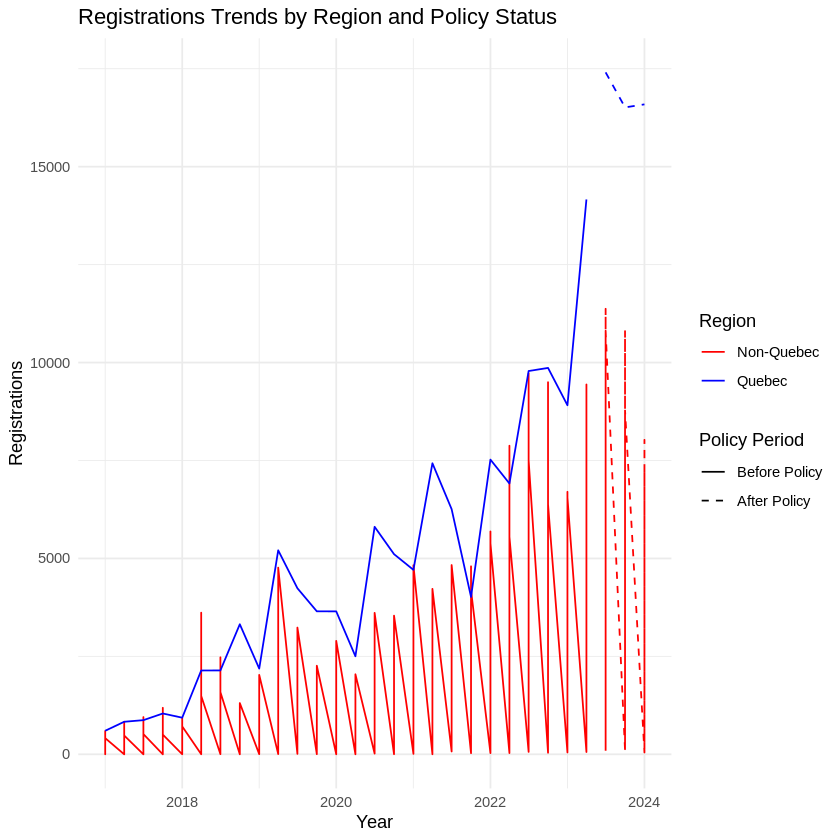

In [307]:
library(ggplot2)

# Convert is_quebec and after_policy to factors if they're not already
aggregated_df$is_quebec <- factor(aggregated_df$is_quebec, levels = c(0, 1), labels = c("Non-Quebec", "Quebec"))
aggregated_df$after_policy <- factor(aggregated_df$after_policy, levels = c(0, 1), labels = c("Before Policy", "After Policy"))

# Assuming aggregated_df is correctly set up and the necessary libraries are loaded
ggplot(aggregated_df, aes(x = ref_date, y = registrations, color = is_quebec, linetype = after_policy)) +
  geom_line() +  # Use line geometry to represent data trends over time
  labs(title = "Registrations Trends by Region and Policy Status",
       x = "Year",
       y = "Registrations",
       color = "Region",
       linetype = "Policy Period") +
  scale_color_manual(values = c("red","blue")) +  # Ensure colors are correctly assigned to factor levels
  scale_linetype_manual(values = c("solid",  "dashed")) +  # Ensure line types are correctly assigned
  theme_minimal()  # Use a minimalistic theme for a clean look


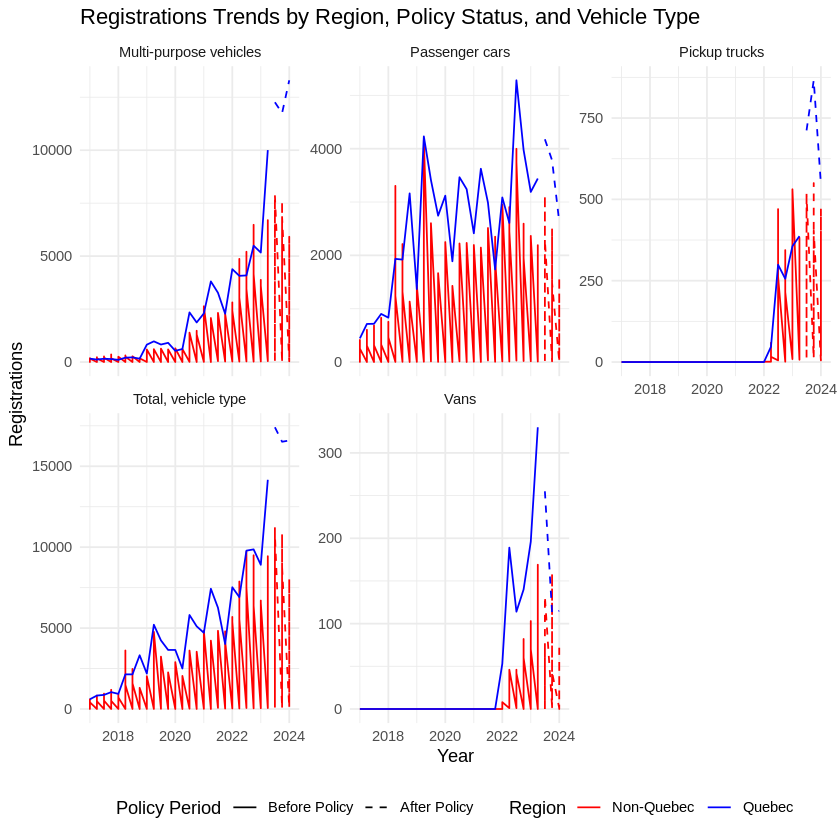

In [308]:
# facet by provinces
df$is_quebec <- factor(df$is_quebec, levels = c(0, 1), labels = c("Non-Quebec", "Quebec"))
df$after_policy <- factor(df$after_policy, levels = c(0, 1), labels = c("Before Policy", "After Policy"))

# Create the plot with facets for each vehicle type
ggplot(df, aes(x = ref_date, y = registrations, color = is_quebec, linetype = after_policy)) +
  geom_line() +  # Use line geometry to show trends
  facet_wrap(~ vehicle_type, scales = "free_y") +  # Create separate plots for each vehicle type
  labs(title = "Registrations Trends by Region, Policy Status, and Vehicle Type",
       x = "Year",
       y = "Registrations",
       color = "Region",
       linetype = "Policy Period") +
  scale_color_manual(values = c("red", "blue")) +  # Customize colors for clarity
  scale_linetype_manual(values = c("solid", "dashed")) +  # Customize line types for before and after policy
  theme_minimal() +  # Use a minimal theme for a clean look
  theme(legend.position = "bottom")  # Position the legend at the bottom for better accessibility


Things to do:

* check linear model assumptions and DID assumptions, make conclusions about assumptions
* add covariates
* introduce mixture